# 出力にシグモイドをかけた時系列を作成する。

In [1]:
import argparse
import os
path = os.getcwd()
path=path[:path.find('estimate-innovation')+20]
# No = (os.path.basename(__file__))[-4]
No = "0" # notebook用
# print('実験No.'+No)
import warnings
warnings.simplefilter('ignore')# 警告を非表示
import numpy as np
np.set_printoptions(precision=4, floatmode='fixed', suppress=True)
import matplotlib.pyplot as plt
from scipy import stats
import math
import sys
sys.path.append(path)
import random
import time
import statsmodels.api as sm
from scipy.stats import norm
import japanize_matplotlib
from scipy.stats import gaussian_kde

import torchvision.transforms as transforms
from torchvision.utils import save_image

import torch.nn as nn
import torch.nn.functional as F
import torch
from torch.autograd import Variable
# 人工データを生成してくれる機械が置いてあるところ
import tsModel
# 学習用のニューラルネットが置いてあるところ
import models
# p-Wasserstein距離の関数
import Wasserstein
path

'/home/lab/ryuichi/Documents/research/estimate-innovation/'

出力に$\frac{1-e^{-cx}}{1+e^{-cx}}$をかます

In [22]:
def sigmoid(x, c=2):
    return  (1 - np.exp(-c*x)) / (1 + np.exp(-c*x))

def nonLinearARIMA(a=[0], b=[0], d =None, mu=0, sigma=1,N=1000, random_seed=0, burn_in=None, randomness="normal", return_innovation=False, c=2):
    # 乱数の初期化
    np.random.seed(random_seed)
    
    # 係数をnumpy.ndarrayに変えておく
    a = np.array(a)
    b = np.array(b)
    
    # 次数の取得
    p =  0 if (a == np.array([0])).prod() else len(a)
    q =  0 if (b == np.array([0])).prod() else len(b)
    
    # ARMAかARIMAか判定
    if d==None:
        ARIMA_flg=False
        d=0
    else:
        ARIMA_flg=True
    
    # burn-in期間の設定
    margin = max(p, q, d)
    if burn_in==None:
        burn_in = 100*margin
    
    # 乱数epsilonの作成
    if randomness=="normal":
        # print("正規乱数")
        random = np.random.normal(loc=mu, scale=sigma, size=N+burn_in+margin)
    elif randomness=="uniform":
        # print("一様乱数")
        random=np.random.uniform(low=mu-np.sqrt(3)*sigma, high=mu+np.sqrt(3)*sigma, size=N+burn_in+margin)
    elif randomness=="gamma":
        # print("移動ガンマ乱数")
        # sigmaの値は最大でも4くらい。これ以上大きいと分散がずれる
        random=np.random.gamma(shape=4/(9*sigma**2), scale=3/2*sigma**2, size=N+burn_in+margin)+mu-2/3
    elif randomness=="normal&uniform":
        # print("正規分布＆一様分布")
        random=np.random.normal(loc=mu, scale=sigma, size=N+burn_in+margin)
        random[-(N-1)//2:]=np.random.uniform(low=mu-np.sqrt(3)*sigma, high=mu+np.sqrt(3)*sigma, size=N//2)
    elif randomness=="normal&gamma":
        # print("正規分布＆移動ガンマ分布")
        random=np.random.normal(loc=mu, scale=sigma, size=N+burn_in+margin)
        random[-(N-1)//2:]=np.random.gamma(shape=4/(9*sigma**2), scale=3/2*sigma**2, size=N//2)+mu-2/3
    elif randomness=="normal&normal":
        # print("正規分布＆分散2倍の正規分布")
        random=np.random.normal(loc=mu, scale=sigma, size=N+burn_in+margin)
        random[-(N-1)//2:]=np.random.normal(loc=mu, scale=2*sigma, size=N//2)
    else:
        random = np.zeros(shape=(N+burn_in+margin))
    if return_innovation:
        return random[-N:]
    
    # 初期値は0
    ts = np.zeros_like(random)
    
    for i in range(margin, N+burn_in+margin):
        ts[i] = sigmoid( (a*np.flip(ts[i-p:i])).sum() + (b*np.flip(random[i-q:i])).sum() + random[i], c=c )
    
    if ARIMA_flg:
        for _ in range(d):
            for i in range(margin, N+burn_in+margin):
                ts[i] = sigmoid( ts[i] + ts[i-1], c=c )
            
    return ts[burn_in+margin:]

In [33]:
phi_a = [1.0, -0.5, 0.7, -0.4]
# phi_b = [1, -0.5]
phi_b = [0]
p = len(phi_a)
q = len(phi_b)
dataSeed=5
N = 1000
data = nonLinearARIMA(a=phi_a, b=phi_b, N=N, random_seed=dataSeed, randomness='uniform', sigma=1/np.sqrt(3))
inno = nonLinearARIMA(a=phi_a, b=phi_b, N=N, random_seed=dataSeed, randomness='uniform', return_innovation=True, sigma=1/np.sqrt(3))

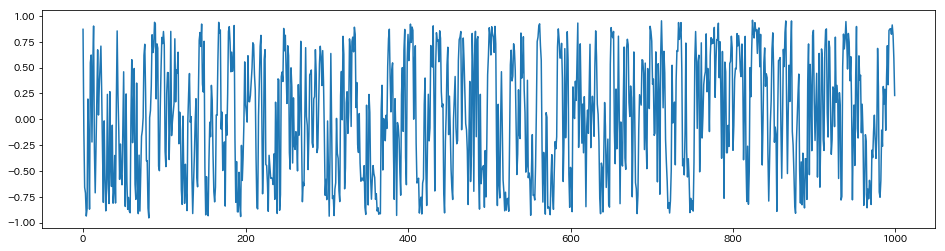

In [34]:
plt.figure(figsize=(16,4))
plt.plot(data)